<a href="https://colab.research.google.com/github/Malbasahi/OIBSIP-Car_Price-Prediction/blob/main/Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV

In [86]:
data = pd.read_csv('cardata.csv')

In [87]:
data

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


In [88]:
# Data cleaning
# 1. Remove duplicate rows
data = data.drop_duplicates()

In [89]:
# 2. Handle missing values if any
# Example: Check for missing values and fill them with the mean
data.fillna(data.mean(), inplace=True)

<ipython-input-89-2dee680ffe23>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)
<ipython-input-89-2dee680ffe23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(data.mean(), inplace=True)


In [90]:
# 3. Convert 'Year' to age by subtracting from the current year
current_year = 2023
data['Age'] = current_year - data['Year']
data.drop('Year', axis=1, inplace=True)

<ipython-input-90-794b021ac6a6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Age'] = current_year - data['Year']
<ipython-input-90-794b021ac6a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('Year', axis=1, inplace=True)


In [91]:
# Data preprocessing
# 4. Encoding categorical variables
# Use one-hot encoding to convert 'Fuel_Type', 'Selling_type', and 'Transmission' to numerical values
data = pd.get_dummies(data, columns=['Fuel_Type', 'Selling_type', 'Transmission'], drop_first=True)

In [92]:
# 5. Feature scaling
# Scale 'Present_Price', 'Driven_kms', and 'Age' using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[['Present_Price', 'Driven_kms', 'Age']] = scaler.fit_transform(data[['Present_Price', 'Driven_kms', 'Age']])

In [93]:
# 6. Drop unnecessary columns
data.drop('Car_Name', axis=1, inplace=True)

In [94]:
# Now, the dataset is cleaned and preprocessed. this dataset will be used for machine learning.
# X will contain the feature columns, and y will contain the target (Selling_Price).
X = data.drop('Selling_Price', axis=1)
y = data['Selling_Price']

In [95]:
# Standardize the feature columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)  # Specify the number of principal components you want to keep
X_pca = pca.fit_transform(X_scaled)

In [96]:
# examine how much variance is explained by the principal components
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [0.33941003 0.20059392]


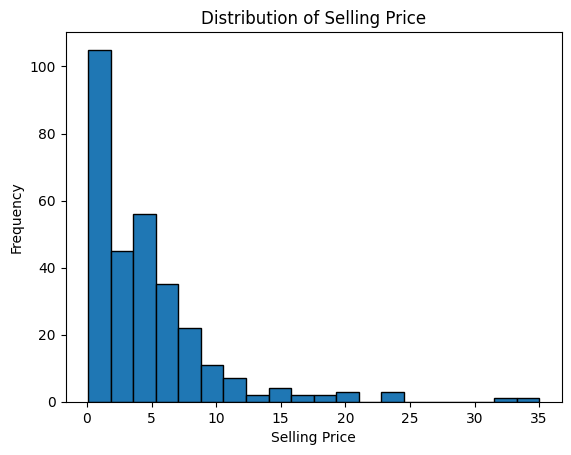

In [97]:
plt.hist(data['Selling_Price'], bins=20, edgecolor='k')
plt.title('Distribution of Selling Price')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.show()

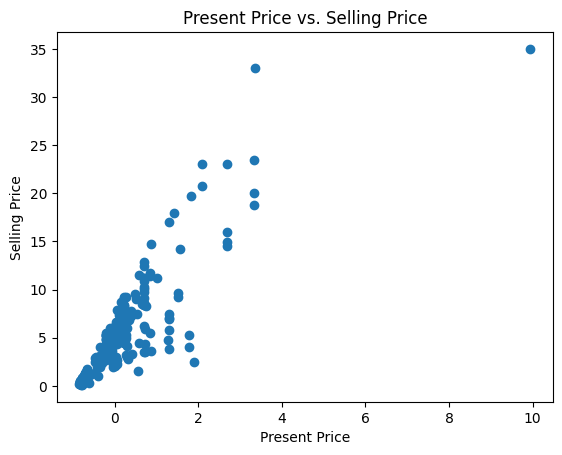

In [98]:
plt.scatter(data['Present_Price'], data['Selling_Price'])
plt.title('Present Price vs. Selling Price')
plt.xlabel('Present Price')
plt.ylabel('Selling Price')
plt.show()

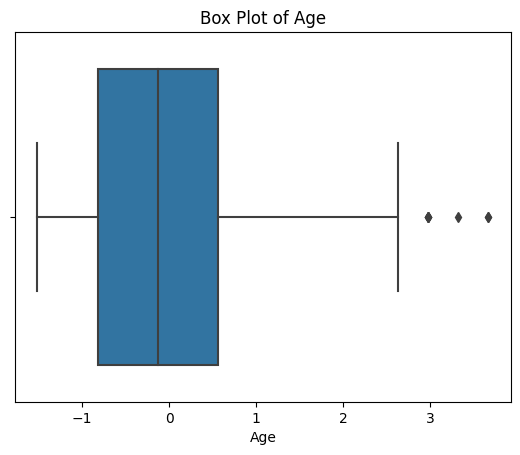

In [99]:
sns.boxplot(x=data['Age'])
plt.title('Box Plot of Age')
plt.xlabel('Age')
plt.show()

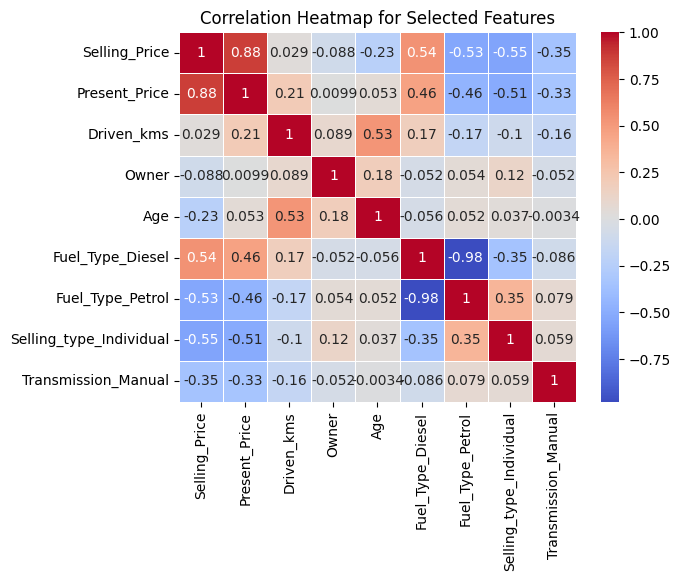

In [100]:
selected_features = data[['Selling_Price', 'Present_Price', 'Driven_kms', 'Owner', 'Age',
                         'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Selling_type_Individual', 'Transmission_Manual']]
correlation_matrix = selected_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Selected Features')
plt.show()

In [101]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [102]:
# Example of more extensive hyperparameter tuning
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 20, 25],
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Improved Best Hyperparameters:", best_params)
print("Improved Root Mean Squared Error (RMSE):", rmse)
print("Improved R-squared (R2) Score:", r2)

Improved Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 200}
Improved Root Mean Squared Error (RMSE): 2.34787562341598
Improved R-squared (R2) Score: 0.7861147767984927


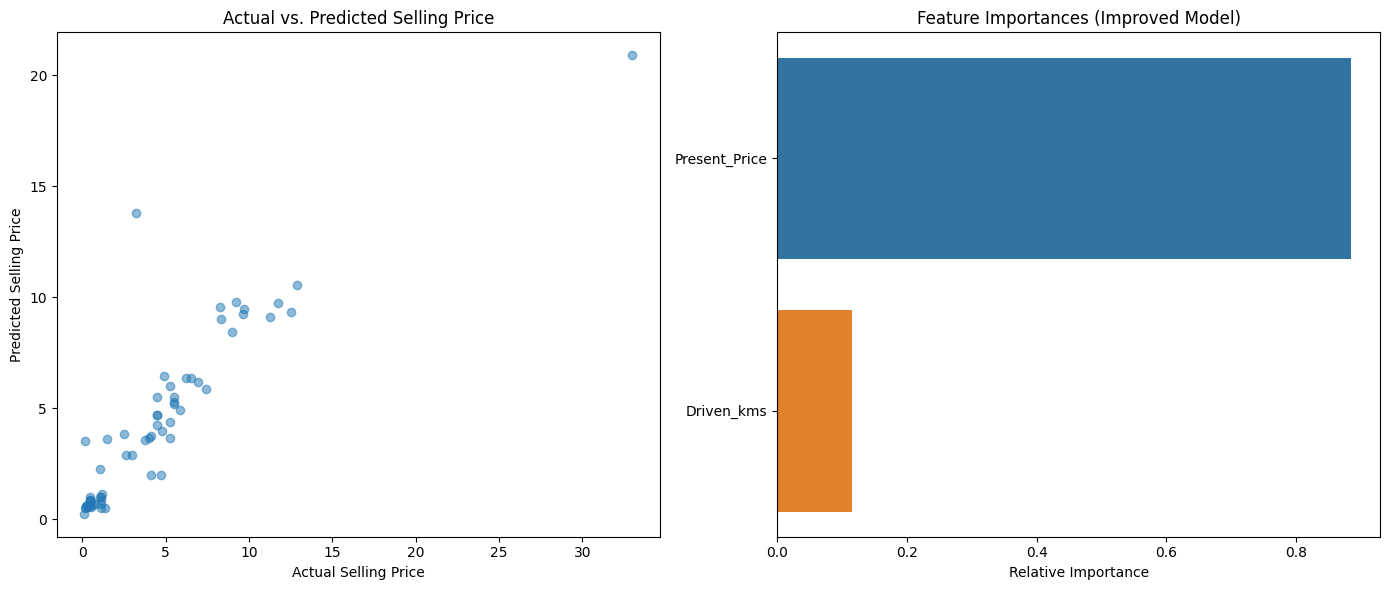

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Visualize actual vs. predicted prices
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].set_xlabel("Actual Selling Price")
axes[0].set_ylabel("Predicted Selling Price")
axes[0].set_title("Actual vs. Predicted Selling Price")

# Visualize feature importances for the improved model
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

sns.barplot(x=importances[indices], y=X.columns[indices], ax=axes[1])
axes[1].set_title("Feature Importances (Improved Model)")
axes[1].set_xlabel("Relative Importance")

plt.tight_layout()
plt.show()
